<a href="https://colab.research.google.com/github/lutharsanen/tal-feature-engineering/blob/main/Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Here, we will go through some basics usage of detectron2 by running inference on images, with an existing detectron2 model.


# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

ModuleNotFoundError: No module named 'torch'

In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 60.1MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=c822bbcec09b58fa3d1142df2a09518866b6cc399ec90b631ca2d644848b0364
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the keyframes dataset:

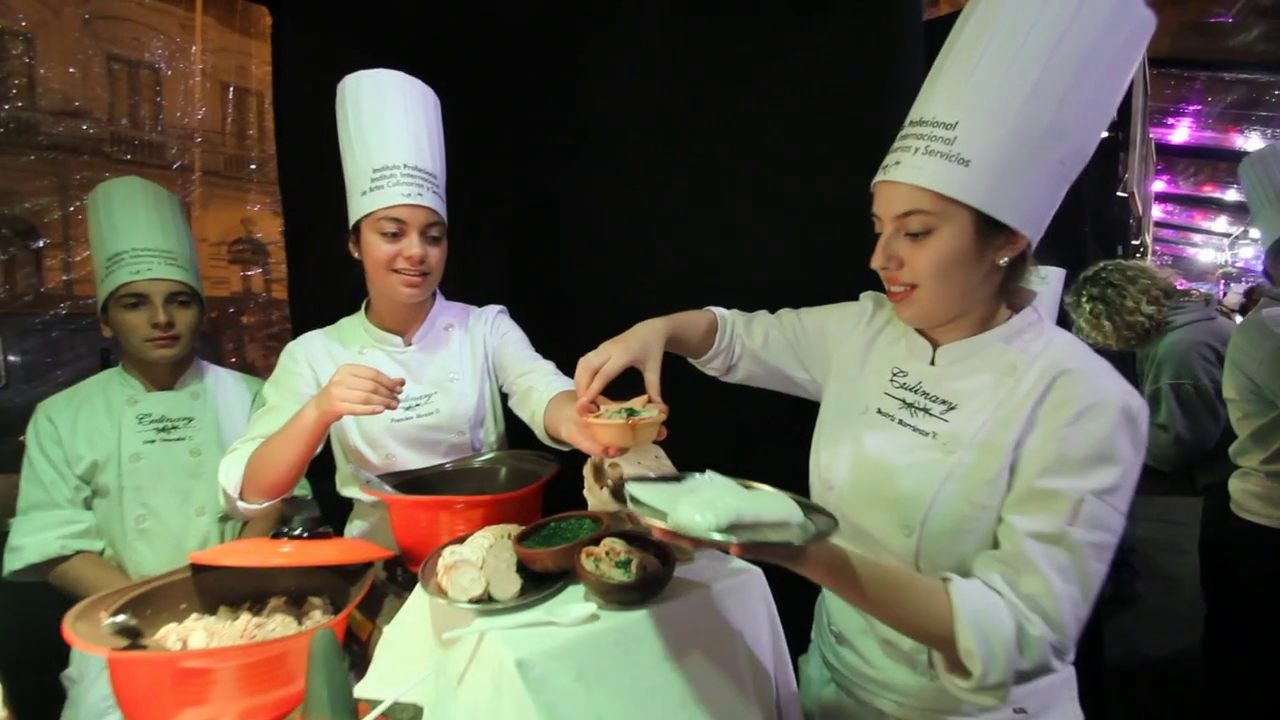

In [13]:
im = cv2.imread("./shot00181_43_RKF.png")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [17]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
#cfg.merge_from_file(model_zoo.get_config_file("LVISv0.5-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_1x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("LVISv0.5-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_1x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_68b088.pkl: 421MB [00:34, 12.0MB/s]                           


In [18]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0,  0, 45, 45, 44,  0, 45, 45, 45,  0, 60], device='cuda:0')
Boxes(tensor([[ 577.4764,    9.8300, 1159.1725,  713.0029],
        [   6.8438,  173.1863,  271.0988,  710.3025],
        [ 226.4319,   70.9076,  654.1197,  546.7699],
        [ 574.4944,  529.8822,  675.6788,  600.6712],
        [ 512.0697,  510.0544,  609.2212,  572.7156],
        [ 103.0200,  610.5032,  148.5221,  646.4334],
        [1214.1108,  239.1172, 1279.6132,  682.1912],
        [ 360.5434,  448.6703,  561.3163,  564.8723],
        [ 584.1622,  403.0713,  666.4498,  452.4400],
        [  76.7835,  559.7401,  391.5179,  717.6194],
        [1104.8475,  258.4984, 1243.9136,  478.0773],
        [ 313.0901,  434.5194,  813.7980,  715.9010]], device='cuda:0'))


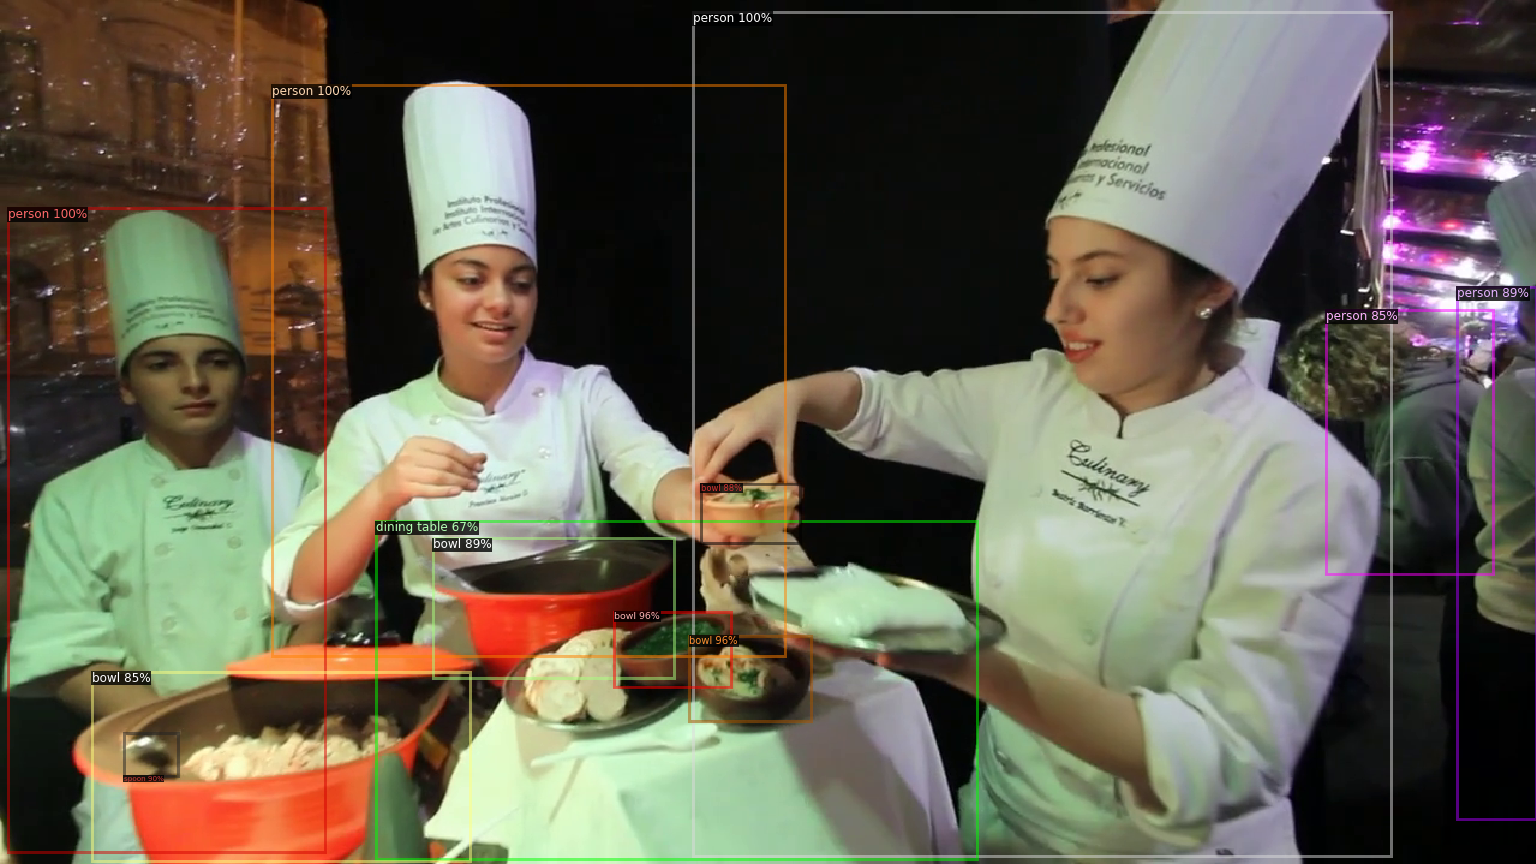

In [20]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Other types of builtin models

We showcase simple demos of other types of models below:

model_final_cafdb1.pkl: 261MB [00:22, 11.8MB/s]                           


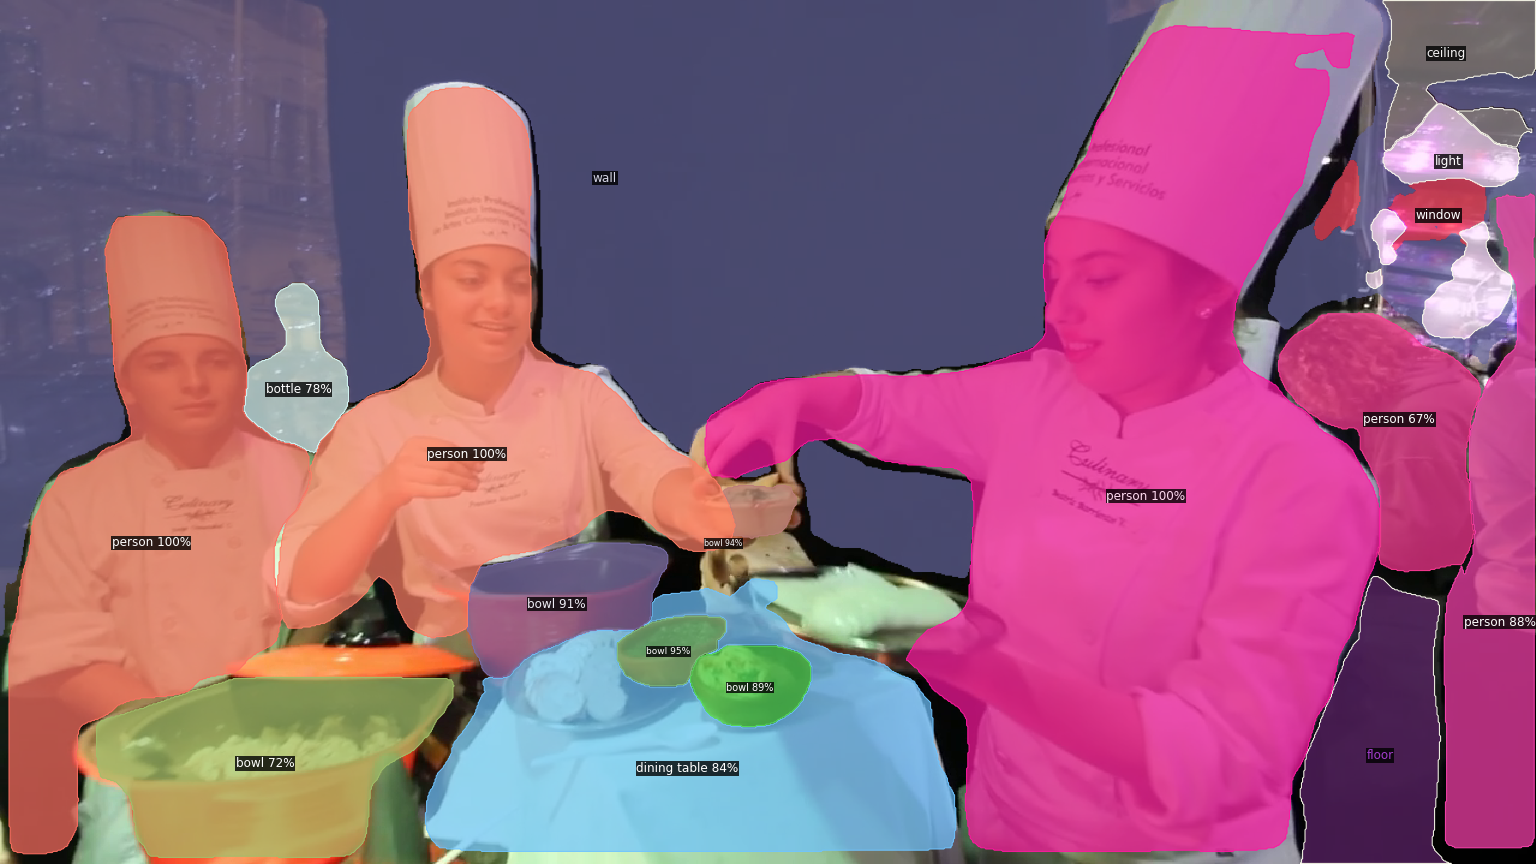

In [21]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])